# QuantumSim - 2 x 2 Sudoku Solver
Author: Nico Kuijpers<br>
Date: January 3, 2025

In this notebook we use Grover's search algorithm to solve a $2 \times 2$ Sudoku puzzle with and without known values.

The notebook is based on the following notebook and blog post, but uses QuantumSim instead of Qiskit:

https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb

https://blog.theodo.com/2022/10/quantum-sudoku/

In [1]:
from quantumsim import *

Assume a $2 \times 2$ by Sudoku puzzle. Four values have to be filled in, let's call them $v_0$, $v_1$, $v_2$, and $v_3$.

|  $v_0$  |  $v_1$  | 
|---------|---------|
|  $v_2$  |  $v_3$  | 

Since it is a $2 \times 2$ Sudoku puzzle, the only values allowed are $0$ and $1$.

A correct solution satisfies the following constraints:
1. $v_0 \neq v_1$
2. $v_0 \neq v_2$
3. $v_1 \neq v_3$
4. $v_2 \neq v_3$

These constraints are coded in the *clause_list* below.

In [2]:
# Constraints for a 2 x 2 Sudoku puzzle
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

To check these constraints, an exclusive OR (XOR) gate is used. 
The XOR operation of two binary values $A$ and $B$ is denoted by $A \oplus B$ and
is defined by the following truth table

| $A$ | $B$ | $A \oplus B$ |
|:---:|:---:|:------------:|
|  0  |  0  |       0      |
|  0  |  1  |       1      |
|  1  |  0  |       1      |
|  1  |  1  |       0      |

Thus $A \oplus B = 1$ if and only if $A \neq B$. 

In quantum computing, a XOR gate can be realized by two CNOT gates with control qubits $a$ and $b$ and target qubit the output qubit.

Below a function *XOR* is defined which extends a quantum circuit with an XOR operation. Qubits $a$ and $b$ are input qubits and
$c$ is the output qubit.

In [3]:
def XOR(circuit:Circuit, a:int, b:int, c:int):
    circuit.cnot(a, c)
    circuit.cnot(b, c)

Using the clause list and the XOR operation, an oracle can be created for the $2 \times 2$ Sudoku puzzle. 
The first $4$ qubits represent $v_0$, $v_1$, $v_2$, and $v_3$ and are called *value_qubits*. 
The next $4$ qubits will be used to check the constraints and are called *clause_qubits*.
An extra qubit is added which will be in state $|1\rangle$ when the solution is valid. This qubit is called the *output* qubit.

The oracle is constructed as follows:

1. Determine the number of qubits and create a circuit.
2. For each clause in the *clause_list* add an XOR operation with the value qubits as input and the respective clause qubit as output.
3. Apply a multi-controlled Pauli X operation with all clause qubits as control and the *output* qubit as target.
4. Repeat step 2 to reset the clause qubits.

Below a function is defined to create a Sudoku oracle.

In [4]:
def create_sudoku_oracle(clause_list:list[int,int], nr_value_qubits:int) -> Circuit:

    # Determine the number of qubits and create a circuit
    nr_clause_qubits = len(clause_list)
    nr_qubits = nr_value_qubits + nr_clause_qubits + 1
    circuit = Circuit(nr_qubits)

    # Set the values for the clause qubits
    q = nr_value_qubits
    for clause in clause_list:
        XOR(circuit, clause[0], clause[1], q)
        q = q + 1

    # Flip 'output' qubit if all clauses are satisfied
    clause_circuit = Circuit(nr_clause_qubits + 1)
    clause_circuit.multi_controlled_pauli_x()
    circuit.append_circuit_general(clause_circuit, nr_value_qubits)

    # Reset the clause qubits
    q = nr_value_qubits
    for clause in clause_list:
        XOR(circuit, clause[0], clause[1], q)
        q = q + 1
    
    return circuit
   

The next step is to constuct a diffusion operator, or *diffuser*. The diffuser acts on the value qubits only. 
For the $2 \times 2$ Sudoku solver, it is taken into account that some of the values $v_0$, $v_1$, $v_2$, and $v_3$ may be known.

For an explanation of the role of the diffuser in Grover's algorithm, we refer to this Qiskit notebook:

https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb

For an intuitive explanation of a diffuser which takes the known values into account, 
we refer to this blog by Ivan Popkov:

https://blog.theodo.com/2022/10/quantum-sudoku/

Below a function is described to create a diffuser to solve a $2 \times 2$ Sudoku puzzle. Input parameters are the number of value qubits
*nr_value_qubits* and a list of qubits for which the values have to be filled in, the *unknown_qubits*.

In [5]:
def create_diffuser(nr_value_qubits:int, unknown_qubits:list[int]) -> Circuit:

    # Create a circuit for the diffuser
    circuit = Circuit(nr_value_qubits)

    # Apply transformation |s> -> |00..0> (using H-gates)
    for q in unknown_qubits:
        circuit.hadamard(q)

    # Apply transformation |00..0> -> |11..1> (using X-gates)
    for q in unknown_qubits:
        circuit.pauli_x(q)

    # Apply a multi-controlled Z gate (using H-gates and a Toffoli gate)
    controls = [q for q in range(nr_value_qubits-1) if q in unknown_qubits]
    target = nr_value_qubits - 1
    circuit.hadamard(target)
    circuit.generic_toffoli(controls, target)
    circuit.hadamard(target)

    # Apply transformation |11..1> -> |00..0> (using X-gates)
    for q in unknown_qubits:
        circuit.pauli_x(q)

    # Apply transformation |00..0> -> |s> (using H-gates)
    for q in unknown_qubits:
        circuit.hadamard(q)

    return circuit

Below, a function is defined to create the Grover circuit. This function has as input parameters *clause_list*, *known_values*, *nr_values*, and *nr_iterations*.
Parameter *known_values* is a dictionary with entry numbers ($0$, $1$, $2$ or $3$) as key and the known value ($0$ or $1$) as value. 
Parameter *nr_iterations* determines how many times the oracle and the diffuser are repeated in the Grover circuit.

Using Hadamard gates, the unknown value qubits (*unknown_qubits*) are brought into superposition. 
The known value qubits (*known_qubits*) are brought into states $|0\rangle$ or $|1\rangle$
depending on the values in the *known_values* dictionary.
The clause qubits have initial state $|0\rangle$.

Below a function is defined to create a Grover circuit to solve a $2 \times $ Sudoku puzzle.

In [6]:
def create_grover_circuit(clause_list:list[int,int], known_values:dict, nr_values:int, nr_iterations:int) -> Circuit:
    
    # List of qubits for which values are already known
    known_qubits = list(known_values.keys())
    
    # List of qubits for which values will be be calculated
    unknown_qubits = [q for q in range(nr_values) if q not in known_qubits]

    # Create the Sudoku oracle for the 2 x 2 Sudoku puzzle
    sudoku_oracle = create_sudoku_oracle(clause_list, nr_values)

    # Create the Grover circuit with same number of qubits
    circuit = Circuit(sudoku_oracle.N)

    # Initialize the output qubit in state |->
    output_qubit = nr_values + len(clause_list)
    circuit.pauli_x(output_qubit)
    circuit.hadamard(output_qubit)

    # Initialize the value qubits
    for q in range(nr_values):
        if q in known_qubits:
            # Qubits are in the |0> state by default
            # If the value of the known qubit is 1, the state is 
            # changed to |1> by applying a Pauli X gate
            if known_values[q] == 1:
                circuit.pauli_x(q)
        if q in unknown_qubits:
            # Unknown qubits are initialized in the |+> state with a Hadamard gate
            circuit.hadamard(q)    
        
    # Create the diffuser
    diffuser = create_diffuser(nr_values, unknown_qubits)

    # Add the Sudoku oracle and diffuser nr_iterations times
    for i in range(nr_iterations):
        # Apply the Sudoku oracle
        circuit.append_circuit(sudoku_oracle)

        # Apply the diffuser
        circuit.append_circuit_general(diffuser, 0)

    # Bring the output qubit to one of the basis states |0> or |1>
    circuit.hadamard(output_qubit)

    return circuit

Below, a Grover circuit with no known qubits is created. In this case, two solutions are possible:

|  $v_0 = 0$  |  $v_1 = 1$  | 
|-------------|-------------|
|  $v_2 = 1$  |  $v_3 = 0$  | 

and

|  $v_0 = 1$  |  $v_1 = 0$  | 
|-------------|-------------|
|  $v_2 = 0$  |  $v_3 = 1$  |

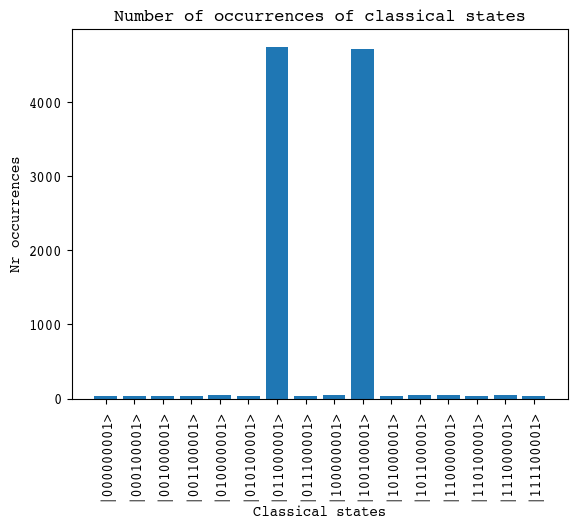

In [7]:
nr_values = 4
nr_iterations = 2
# Case 1: no known values => 2 possible solutions: 0110 and 1001
known_values = {}
circuit = create_grover_circuit(clause_list, known_values, nr_values, nr_iterations)
result = QuantumUtil.measure_circuit(circuit, 10000)
QuantumUtil.histogram_of_classical_states(result)

The two most occurring classical states are $|011000001\rangle$ and $|100100001\rangle$. 
Indeed, these states represent the two possible solutions.

Below, a function is defined to print the solutions found by the Grover circuit. 
It is assumed that all classical states occurring more than $1000$ times are valid solutions.

In [8]:
from collections import Counter

def print_solutions(result:list[str]):
    counts = Counter(result)
    frequent_strings = [string for string, count in counts.items() if count > 1000]
    print("Solutions found:")
    for string in frequent_strings:
        solution = string[1:5]
        print("")
        print("---------")
        print(f"| {solution[0]} | {solution[1]} |")
        print("---------")
        print(f"| {solution[2]} | {solution[3]} |")
        print("---------")

In [9]:
print_solutions(result)

Solutions found:

---------
| 0 | 1 |
---------
| 1 | 0 |
---------

---------
| 1 | 0 |
---------
| 0 | 1 |
---------


Below, a function is defined to create, execute and measure a Grover circuit for given known values. A histogram of measurements is created and the solutions are printed.

In [10]:
def find_solutions(known_values:dict):
    circuit = create_grover_circuit(clause_list, known_values, nr_values=4, nr_iterations=2)
    result = QuantumUtil.measure_circuit(circuit, 10000)
    QuantumUtil.histogram_of_classical_states(result)
    print_solutions(result)


Let's make $v_0$ known to be $0$.

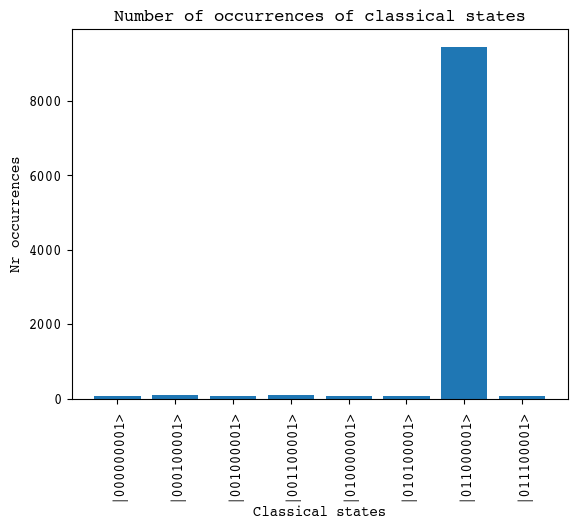

Solutions found:

---------
| 0 | 1 |
---------
| 1 | 0 |
---------


In [11]:
known_values = {0:0}
find_solutions(known_values)

Let's make $v_3$ known to be $1$.

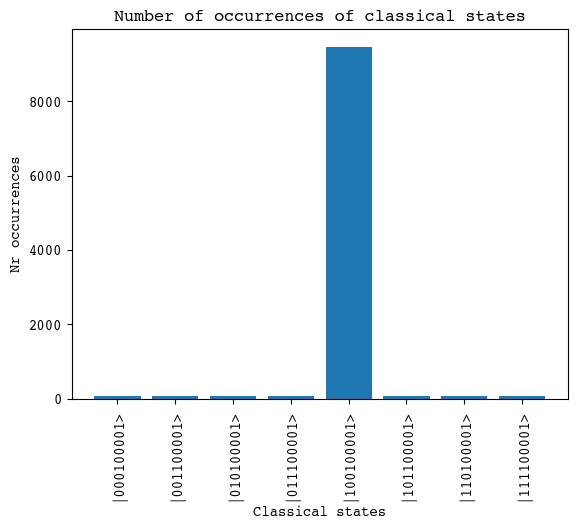

Solutions found:

---------
| 1 | 0 |
---------
| 0 | 1 |
---------


In [12]:
known_values = {3:1}
find_solutions(known_values)